<a href="https://colab.research.google.com/github/chaserobertson/credit-fraud/blob/main/keras_pso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('data/creditcard.csv')
dataset.shape, dataset['Class'].sum()

((284807, 31), 492)

In [2]:
from sklearn.model_selection import train_test_split

y = dataset['Class'].to_numpy()
X = dataset.drop('Class', axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
([i.shape for i in [X_train, X_test, y_train, y_test]], 
 [sum(i) for i in [y_train, y_test]])

([(170884, 30), (113923, 30), (170884,), (113923,)], [314, 178])

In [3]:
from imblearn.over_sampling import SMOTE

X, y = SMOTE().fit_resample(X_train, y_train)
([i.shape for i in [X, X_test, y, y_test]], 
 [sum(i) for i in [y, y_test]])

([(341140, 30), (113923, 30), (341140,), (113923,)], [170570, 178])

In [4]:
data = [X, y, X_test, y_test]

In [5]:
# !/usr/bin/env python
# Created by "Thieu" at 23:58, 14/12/2021 ----------%
#       Email: nguyenthieu2102@gmail.com            %
#       Github: https://github.com/thieu1995        %
# --------------------------------------------------%

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
from mealpy.swarm_based import PSO
# from mealpy.evolutionary_based import FPA
import time


class HybridMlp:

    def __init__(self, dataset, n_hidden_nodes, epoch, pop_size):
        self.X_train, self.y_train, self.X_test, self.y_test = dataset[0], dataset[1], dataset[2], dataset[3]
        self.n_hidden_nodes = n_hidden_nodes
        self.epoch = epoch
        self.pop_size = pop_size

        self.n_inputs = self.X_train.shape[1]
        self.model, self.problem_size, self.n_dims, self.problem = None, None, None, None
        self.optimizer, self.solution, self.best_fit = None, None, None

    def create_network(self):
        # create model
        model = Sequential()
        model.add(Dense(self.n_hidden_nodes[0], input_dim=self.n_inputs, activation='relu'))
        model.add(Dense(self.n_hidden_nodes[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.problem_size = self.n_dims = np.sum([np.size(w) for w in self.model.get_weights()])

    def create_problem(self):
        self.problem = {
            "fit_func": self.fitness_function,
            "lb": [-1, ] * self.n_dims,
            "ub": [1, ] * self.n_dims,
            "minmax": "min",
            "log_to": "console",
            "verbose": True,
            "save_population": True
        }

    def decode_solution(self, solution):
        weight_sizes = [(w.shape, np.size(w)) for w in self.model.get_weights()]
        weights = []
        cut_point = 0
        for ws in weight_sizes:
            temp = np.reshape(solution[cut_point: cut_point + ws[1]], ws[0])
            weights.append(temp)
            cut_point += ws[1]
        self.model.set_weights(weights)

    def prediction(self, solution, x_data):
        self.decode_solution(solution)
        return self.model.predict(x_data)

    def training(self):
        self.create_network()
        self.create_problem()
        self.optimizer = PSO.OriginalPSO(self.epoch, self.pop_size)
        self.solution, self.best_fit = self.optimizer.solve(self.problem, mode='thread')

    def fitness_function(self, solution):
        sample = (np.random.sample(size=1000)*self.X_train.shape[0]).astype('int')
        yhat = self.prediction(solution, self.X_train[sample])
        acc = metrics.brier_score_loss(self.y_train[sample], yhat)
        return acc

2022-10-11 21:00:19.946571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
%%capture
t1 = time.time()

n_hidden_nodes = [10, 5]
epoch = 200
pop_size = 100

# define model
model = HybridMlp(data, n_hidden_nodes, epoch, pop_size)
# fit model
model.training()

t2 = time.time()

2022-10-11 21:00:24.698989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1725.3760733604431


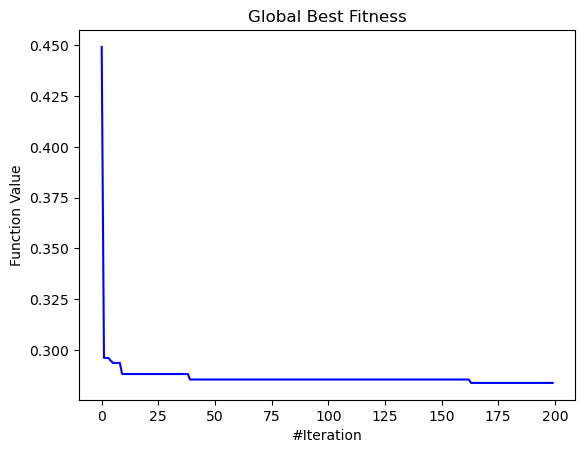

In [7]:
print(t2-t1)
from mealpy.utils.visualize import *
export_convergence_chart(model.optimizer.history.list_global_best_fit, title='Global Best Fitness')

3561/3561 [==============================] - 3s 855us/step
AUROC 0.4999648336190602
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113745
           1       0.00      0.00      0.00       178

    accuracy                           1.00    113923
   macro avg       0.50      0.50      0.50    113923
weighted avg       1.00      1.00      1.00    113923



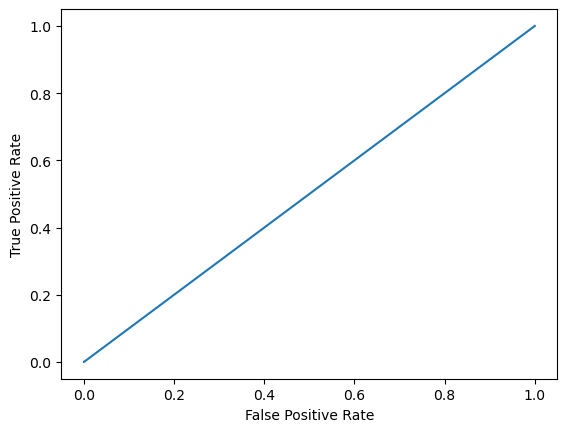

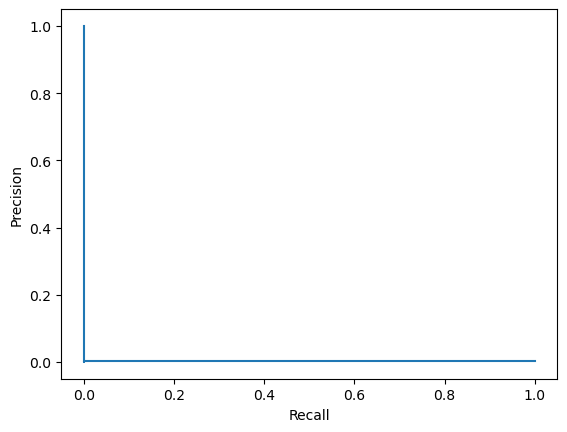

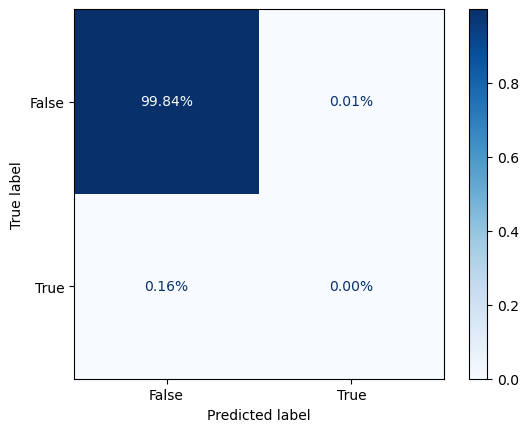

In [8]:
import matplotlib.pyplot as plt
from sklearn import metrics

# evaluate on test set
yhat = model.prediction(solution=model.solution, x_data=X_test)

#calculate precision and recall
precision, recall, thresh = metrics.precision_recall_curve(y_test, yhat)

fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)

y_pred = yhat > threshold[tpr > 0.90][0]
print('AUROC', metrics.roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
disp = metrics.PrecisionRecallDisplay(precision, recall).plot()
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.astype('bool'), y_pred.astype('bool'), cmap='Blues',
    normalize='all', values_format='.2%')